# GARCH Volatility Forecasting for Portfolio Management

This notebook implements GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models for volatility forecasting, including:
- Understanding volatility clustering
- GARCH(1,1) model implementation
- Model diagnostics and validation
- Volatility forecasting
- Portfolio applications (dynamic position sizing, risk management)
- Comparison with other volatility models

In [2]:
!pip install arch

In [3]:
# GARCH modelling
from arch import arch_model             # high-level wrapper
# or, if you want the low-level API
from arch.univariate import GARCH, EGARCH

# Example: GJR-GARCH(1,1,1)
gjr_spec = GARCH(p=1, o=1, q=1)


In [4]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# GARCH modeling
from arch import arch_model
#from arch.univariate import GARCH, EGARCH, GJR

# For interactive plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Portfolio optimization
import sys
sys.path.append('..')
from src.data.fetcher import DataFetcher

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Understanding Volatility Clustering

Volatility clustering is a key stylized fact in financial markets:
- Large price changes tend to be followed by large changes
- Small price changes tend to be followed by small changes
- Volatility is mean-reverting over time

2025-06-18 00:09:09,581 - src.data.fetcher - INFO - DataFetcher initialized
2025-06-18 00:09:09,581 - src.data.fetcher - INFO - Fetching data for ['SPY', 'AAPL', 'GOOGL', 'MSFT', 'JPM'] from 2015-01-01 to 2024-01-01
2025-06-18 00:09:10,035 - src.data.fetcher - INFO - Successfully retrieved data: 2264 rows, 5 columns


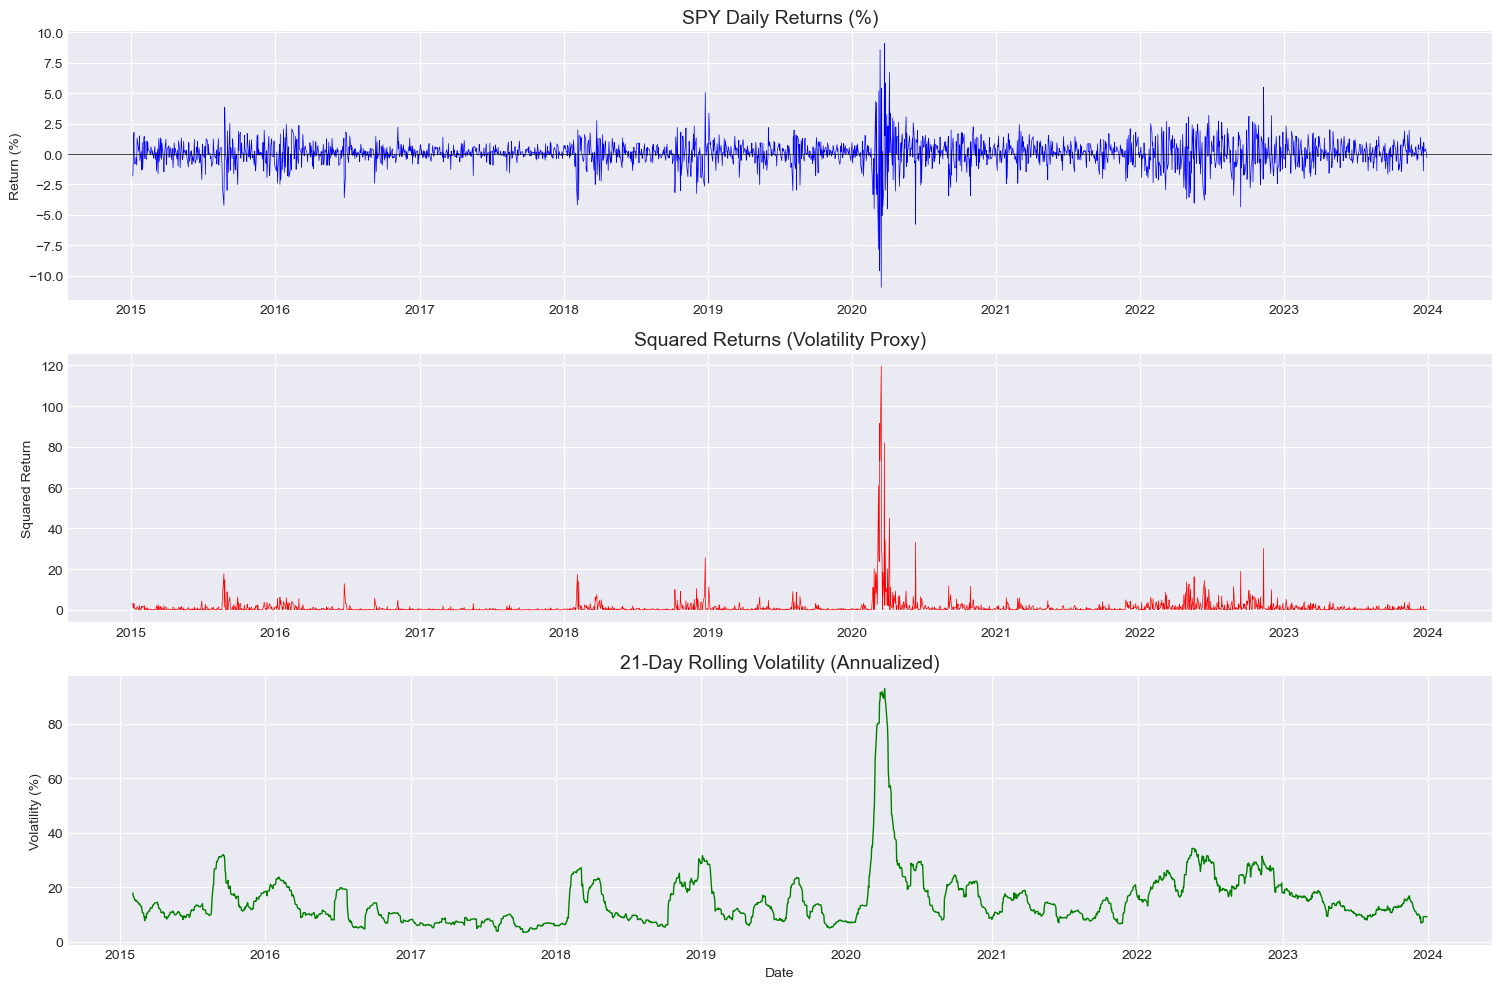

Ljung-Box Test for Volatility Clustering (Squared Returns):
        lb_stat      lb_pvalue
1    519.086957  6.686313e-115
2   1176.720183  3.009254e-256
3   1481.399149   0.000000e+00
4   1772.353767   0.000000e+00
5   2012.123984   0.000000e+00
6   2370.002304   0.000000e+00
7   2592.074943   0.000000e+00
8   2865.949488   0.000000e+00
9   3049.246609   0.000000e+00
10  3203.998229   0.000000e+00

Significant p-values (< 0.05) indicate volatility clustering


In [6]:
# Load data
tickers = ['SPY', 'AAPL', 'GOOGL', 'MSFT', 'JPM']
fetcher = DataFetcher()
prices = fetcher.fetch_price_data(tickers, '2015-01-01', '2024-01-01')

# Calculate returns
returns = prices.pct_change().dropna() * 100  # Convert to percentage
log_returns = np.log(prices / prices.shift(1)).dropna() * 100

# Focus on SPY for initial analysis
spy_returns = returns['SPY']

# Visualize volatility clustering
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Returns
axes[0].plot(spy_returns.index, spy_returns.values, 'b-', linewidth=0.5)
axes[0].set_title('SPY Daily Returns (%)', fontsize=14)
axes[0].set_ylabel('Return (%)')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Squared returns (proxy for volatility)
axes[1].plot(spy_returns.index, spy_returns**2, 'r-', linewidth=0.5)
axes[1].set_title('Squared Returns (Volatility Proxy)', fontsize=14)
axes[1].set_ylabel('Squared Return')

# Rolling volatility
rolling_vol = spy_returns.rolling(window=21).std() * np.sqrt(252)  # Annualized
axes[2].plot(rolling_vol.index, rolling_vol.values, 'g-', linewidth=1)
axes[2].set_title('21-Day Rolling Volatility (Annualized)', fontsize=14)
axes[2].set_ylabel('Volatility (%)')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

# Statistical tests for volatility clustering
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test for autocorrelation in squared returns
lb_test = acorr_ljungbox(spy_returns**2, lags=20, return_df=True)
print("Ljung-Box Test for Volatility Clustering (Squared Returns):")
print(lb_test[['lb_stat', 'lb_pvalue']].head(10))
print("\nSignificant p-values (< 0.05) indicate volatility clustering")

## 2. GARCH Model Theory

### GARCH(1,1) Model:
$$r_t = \mu + \epsilon_t$$
$$\epsilon_t = \sigma_t z_t, \quad z_t \sim N(0,1)$$
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

Where:
- $\omega$ > 0: long-term variance constant
- $\alpha$ ≥ 0: ARCH parameter (reaction to shocks)
- $\beta$ ≥ 0: GARCH parameter (persistence)
- $\alpha + \beta$ < 1: stationarity condition

In [8]:
# Fit GARCH(1,1) model
def fit_garch_model(returns, p=1, q=1, dist='normal'):
    """
    Fit GARCH model to returns
    
    Parameters:
    - returns: return series
    - p: GARCH order
    - q: ARCH order
    - dist: error distribution ('normal', 't', 'skewt')
    """
    model = arch_model(returns, vol='Garch', p=p, q=q, dist=dist)
    results = model.fit(disp='off')
    return model, results

# Fit basic GARCH(1,1)
garch_model, garch_results = fit_garch_model(spy_returns)

# Display results
print(garch_results.summary())

# Extract parameters
omega = garch_results.params['omega']
alpha = garch_results.params['alpha[1]']
beta = garch_results.params['beta[1]']

print("\nGARCH(1,1) Parameters:")
print(f"ω (omega): {omega:.6f}")
print(f"α (alpha): {alpha:.4f}")
print(f"β (beta):  {beta:.4f}")
print(f"α + β:     {alpha + beta:.4f} (persistence)")
print(f"\nUnconditional variance: {omega / (1 - alpha - beta):.4f}")
print(f"Unconditional volatility: {np.sqrt(omega / (1 - alpha - beta)):.2f}%")

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2915.44
Distribution:                  Normal   AIC:                           5838.87
Method:            Maximum Likelihood   BIC:                           5861.77
                                        No. Observations:                 2263
Date:                Wed, Jun 18 2025   Df Residuals:                     2262
Time:                        00:09:10   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0892  1.542e-02      5.787  7.178e-09 [5.900e-0

## 3. Model Diagnostics

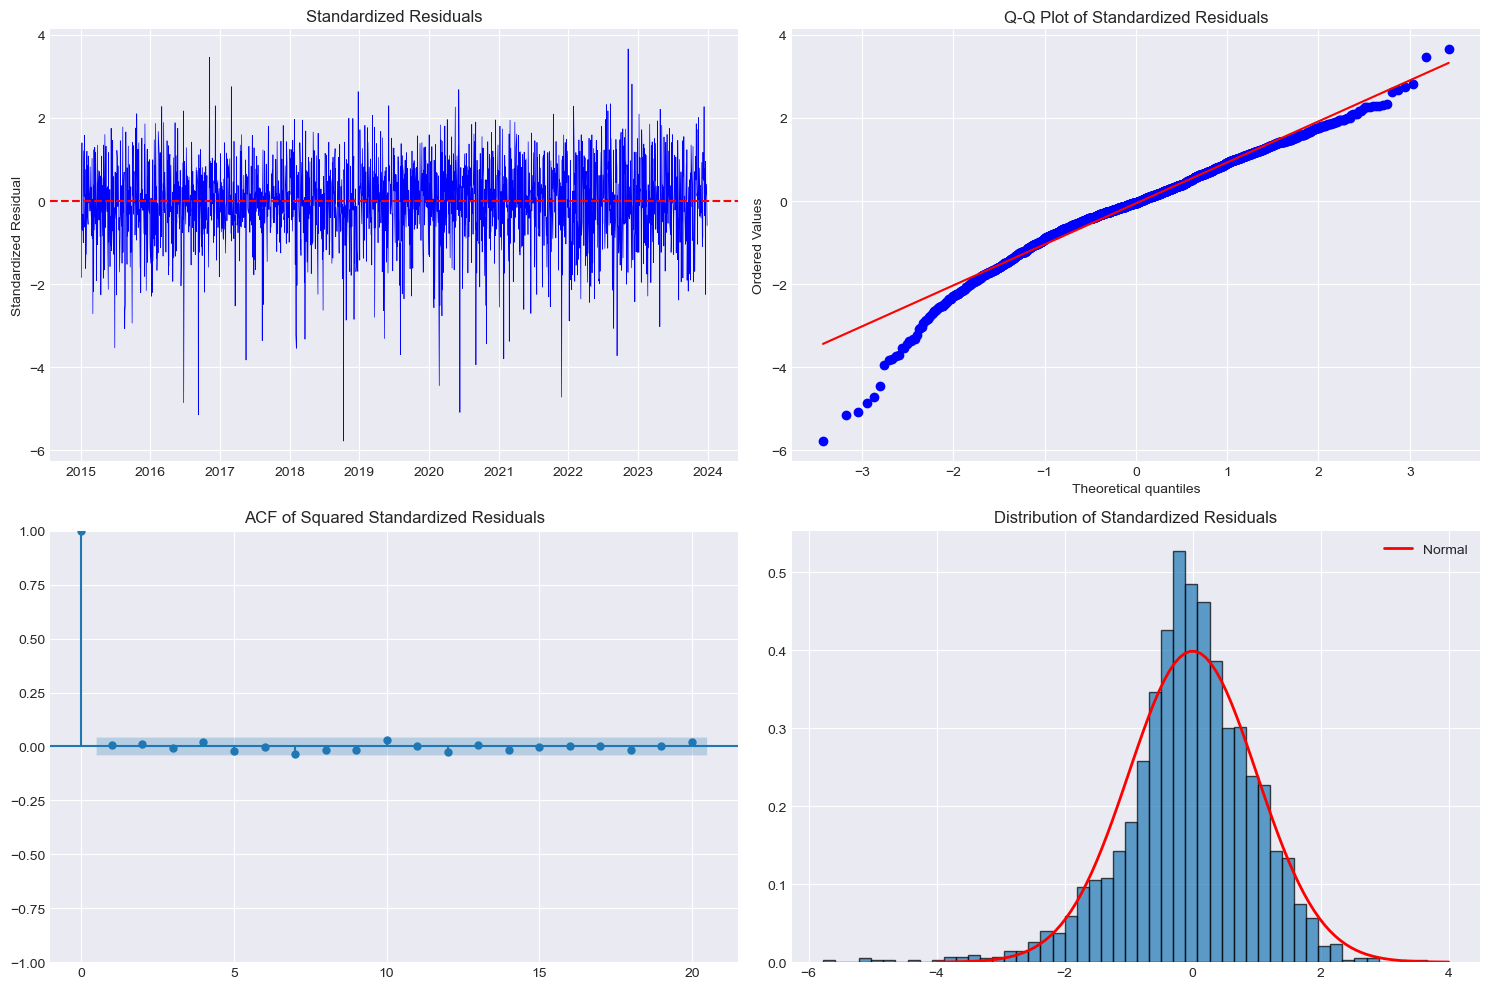

Model Diagnostics:

Ljung-Box test on standardized residuals:
p-value at lag 10: 0.7764

Ljung-Box test on squared standardized residuals:
p-value at lag 10: 0.5812

Jarque-Bera test: statistic = 552.0385, p-value = 0.0000


In [10]:
# Extract conditional volatility
conditional_vol = garch_results.conditional_volatility

# Standardized residuals
std_resid = garch_results.resid / conditional_vol

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Standardized residuals
axes[0, 0].plot(std_resid.index, std_resid.values, 'b-', linewidth=0.5)
axes[0, 0].set_title('Standardized Residuals')
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_ylabel('Standardized Residual')

# 2. QQ plot
stats.probplot(std_resid, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of Standardized Residuals')

# 3. ACF of squared standardized residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(std_resid**2, lags=20, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Squared Standardized Residuals')

# 4. Histogram of standardized residuals
axes[1, 1].hist(std_resid, bins=50, density=True, alpha=0.7, edgecolor='black')
x = np.linspace(-4, 4, 100)
axes[1, 1].plot(x, stats.norm.pdf(x), 'r-', linewidth=2, label='Normal')
axes[1, 1].set_title('Distribution of Standardized Residuals')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Statistical tests
print("Model Diagnostics:")
print("=" * 50)

# Ljung-Box test on standardized residuals
lb_resid = acorr_ljungbox(std_resid, lags=10, return_df=True)
print("\nLjung-Box test on standardized residuals:")
print(f"p-value at lag 10: {lb_resid['lb_pvalue'].iloc[9]:.4f}")

# Ljung-Box test on squared standardized residuals
lb_resid_sq = acorr_ljungbox(std_resid**2, lags=10, return_df=True)
print("\nLjung-Box test on squared standardized residuals:")
print(f"p-value at lag 10: {lb_resid_sq['lb_pvalue'].iloc[9]:.4f}")

# Jarque-Bera test for normality
jb_stat, jb_pvalue = stats.jarque_bera(std_resid)
print(f"\nJarque-Bera test: statistic = {jb_stat:.4f}, p-value = {jb_pvalue:.4f}")

## 4. Alternative GARCH Models

In [12]:
# Compare different GARCH specifications
models = {}

# 1. Standard GARCH(1,1) with normal distribution
models['GARCH-N'] = arch_model(spy_returns, vol='Garch', p=1, q=1, dist='normal')

# 2. GARCH(1,1) with Student's t distribution
models['GARCH-t'] = arch_model(spy_returns, vol='Garch', p=1, q=1, dist='t')

# 3. GJR-GARCH (captures leverage effect)
models['GJR-GARCH'] = arch_model(spy_returns, vol='Garch', p=1, o=1, q=1, dist='t')

# 4. EGARCH (exponential GARCH)
models['EGARCH'] = arch_model(spy_returns, vol='EGARCH', p=1, q=1, dist='t')

# Fit all models
results = {}
for name, model in models.items():
    print(f"Fitting {name}...")
    results[name] = model.fit(disp='off')

# Compare models
comparison = pd.DataFrame({
    name: {
        'Log-Likelihood': res.loglikelihood,
        'AIC': res.aic,
        'BIC': res.bic,
        'Persistence': res.params.get('alpha[1]', 0) + res.params.get('beta[1]', 0)
        if 'EGARCH' not in name else np.nan
    }
    for name, res in results.items()
}).T

print("\nModel Comparison:")
print(comparison.round(4))

# Plot conditional volatilities from different models
fig = go.Figure()

for name, res in results.items():
    fig.add_trace(go.Scatter(
        x=res.conditional_volatility.index,
        y=res.conditional_volatility * np.sqrt(252),  # Annualized
        mode='lines',
        name=name,
        line=dict(width=1)
    ))

fig.update_layout(
    title='Conditional Volatility from Different GARCH Models (Annualized)',
    xaxis_title='Date',
    yaxis_title='Volatility (%)',
    hovermode='x unified',
    height=500
)

fig.show()

Fitting GARCH-N...
Fitting GARCH-t...
Fitting GJR-GARCH...
Fitting EGARCH...

Model Comparison:
           Log-Likelihood        AIC        BIC  Persistence
GARCH-N        -2915.4373  5838.8745  5861.7723       0.9750
GARCH-t        -2849.4394  5708.8789  5737.5011       0.9995
GJR-GARCH      -2815.9748  5643.9495  5678.2962       0.8512
EGARCH         -2855.8598  5721.7197  5750.3419          NaN


## 5. Volatility Forecasting

Best model based on AIC: GJR-GARCH


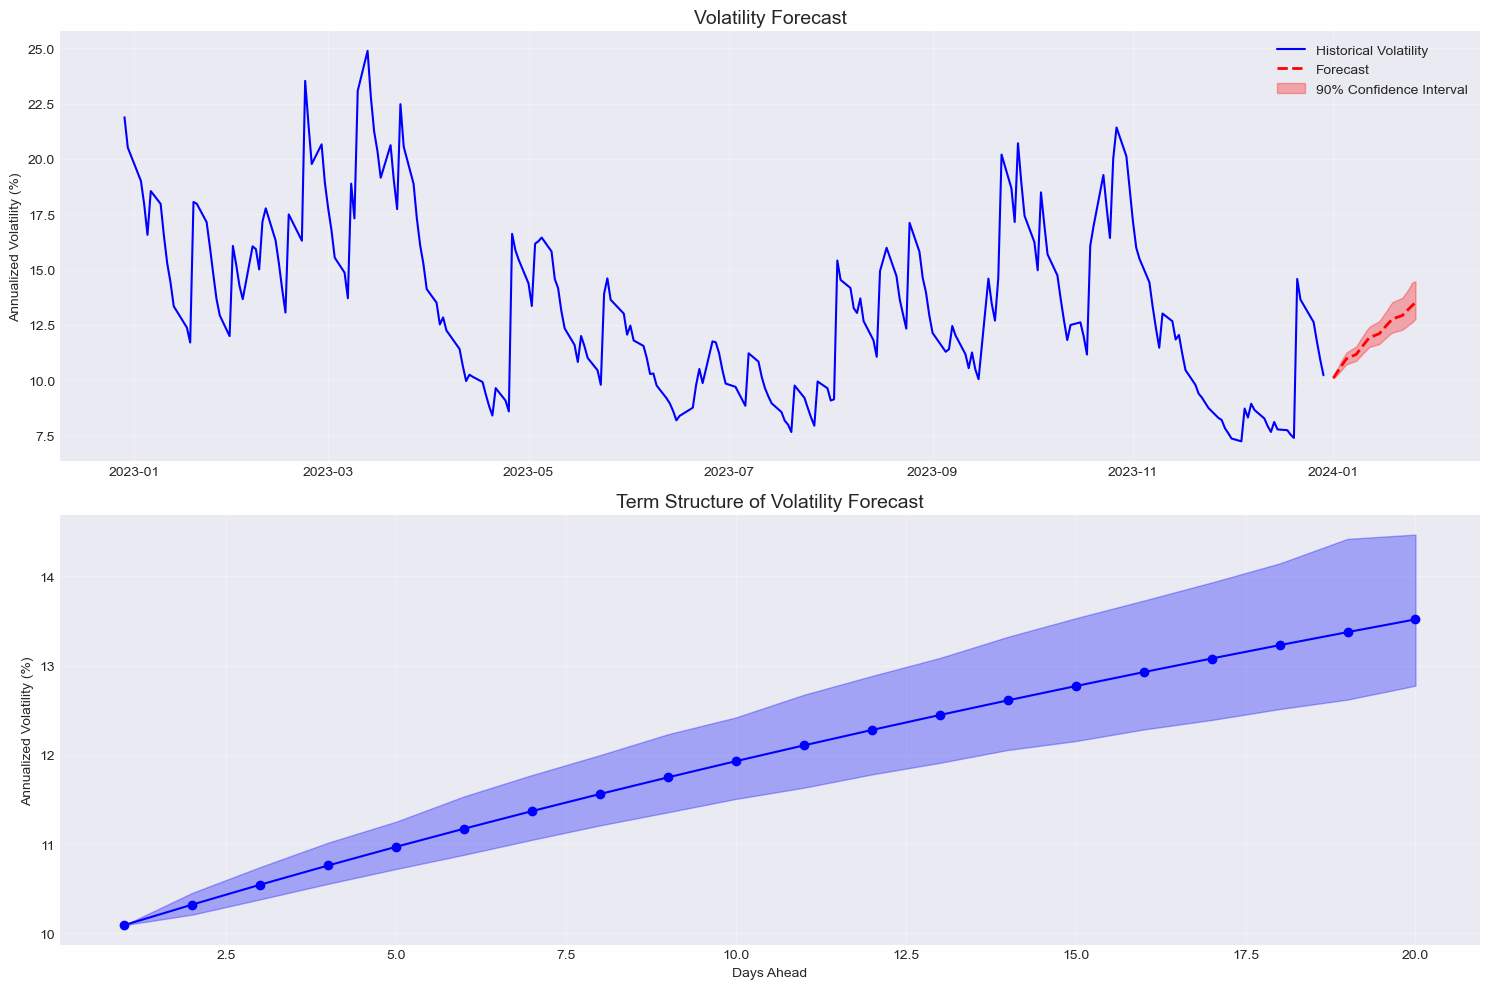


Volatility Forecast Summary (Annualized):
Current volatility: 10.23%
1-day forecast: 10.09%
5-day forecast: 10.97%
20-day forecast: 13.52%


In [14]:
# Generate volatility forecasts
def forecast_volatility(model_result, horizon=20):
    """
    Generate volatility forecasts
    """
    forecasts = model_result.forecast(horizon=horizon)
    variance_forecast = forecasts.variance.values[-1, :]
    volatility_forecast = np.sqrt(variance_forecast)
    
    return volatility_forecast

# Use best model (based on AIC)
best_model_name = comparison['AIC'].idxmin()
best_model_result = results[best_model_name]

print(f"Best model based on AIC: {best_model_name}")

# Generate forecasts
forecast_horizon = 20
vol_forecast = forecast_volatility(best_model_result, horizon=forecast_horizon)

# Create forecast visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Historical volatility with forecast
historical_vol = best_model_result.conditional_volatility * np.sqrt(252)
last_date = historical_vol.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                              periods=forecast_horizon, freq='B')

# Plot historical
ax1.plot(historical_vol.index[-252:], historical_vol.iloc[-252:], 
         'b-', label='Historical Volatility')

# Plot forecast
forecast_series = pd.Series(vol_forecast * np.sqrt(252), index=forecast_dates)
ax1.plot(forecast_series.index, forecast_series.values, 
         'r--', linewidth=2, label='Forecast')

# Add confidence bands (using simulation)
n_sims = 1000
sim_forecasts = []

for _ in range(n_sims):
    sim = best_model_result.forecast(horizon=forecast_horizon, 
                                    method='simulation').variance.values[-1, :]
    sim_forecasts.append(np.sqrt(sim) * np.sqrt(252))

sim_forecasts = np.array(sim_forecasts)
lower_band = np.percentile(sim_forecasts, 5, axis=0)
upper_band = np.percentile(sim_forecasts, 95, axis=0)

ax1.fill_between(forecast_dates, lower_band, upper_band, 
                 alpha=0.3, color='red', label='90% Confidence Interval')

ax1.set_title('Volatility Forecast', fontsize=14)
ax1.set_ylabel('Annualized Volatility (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Term structure of volatility
ax2.plot(range(1, forecast_horizon + 1), vol_forecast * np.sqrt(252), 
         'b-o', markersize=6)
ax2.fill_between(range(1, forecast_horizon + 1), lower_band, upper_band, 
                 alpha=0.3, color='blue')
ax2.set_title('Term Structure of Volatility Forecast', fontsize=14)
ax2.set_xlabel('Days Ahead')
ax2.set_ylabel('Annualized Volatility (%)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print forecast summary
print(f"\nVolatility Forecast Summary (Annualized):")
print(f"Current volatility: {historical_vol.iloc[-1]:.2f}%")
print(f"1-day forecast: {vol_forecast[0] * np.sqrt(252):.2f}%")
print(f"5-day forecast: {vol_forecast[4] * np.sqrt(252):.2f}%")
print(f"20-day forecast: {vol_forecast[-1] * np.sqrt(252):.2f}%")

## 6. Portfolio Applications

In [16]:
# Fit GARCH models to all assets
portfolio_garch_models = {}
portfolio_vol_forecasts = {}

for ticker in tickers:
    print(f"Fitting GARCH for {ticker}...")
    model = arch_model(returns[ticker], vol='Garch', p=1, q=1, dist='t')
    result = model.fit(disp='off')
    portfolio_garch_models[ticker] = result
    
    # Get conditional volatility
    portfolio_vol_forecasts[ticker] = result.conditional_volatility * np.sqrt(252)

# Convert to DataFrame
vol_df = pd.DataFrame(portfolio_vol_forecasts)

# 1. Dynamic Position Sizing based on volatility
def calculate_risk_parity_weights(volatilities):
    """
    Calculate risk parity weights (inverse volatility weighting)
    """
    inv_vol = 1 / volatilities
    return inv_vol / inv_vol.sum()

# Calculate dynamic weights
dynamic_weights = vol_df.apply(lambda row: calculate_risk_parity_weights(row), axis=1)

# Visualize dynamic weights
fig = go.Figure()

for ticker in tickers:
    fig.add_trace(go.Scatter(
        x=dynamic_weights.index,
        y=dynamic_weights[ticker] * 100,
        mode='lines',
        name=ticker,
        stackgroup='one'
    ))

fig.update_layout(
    title='Dynamic Portfolio Weights Based on GARCH Volatility',
    xaxis_title='Date',
    yaxis_title='Weight (%)',
    hovermode='x unified',
    height=500
)

fig.show()

# 2. Volatility-Adjusted Returns (Sharpe Ratio Maximization)
expected_returns = returns.mean() * 252  # Annualized
current_vols = vol_df.iloc[-1]

# Calculate Sharpe ratios
risk_free_rate = 0.02
sharpe_ratios = (expected_returns - risk_free_rate) / current_vols

print("\nCurrent Portfolio Metrics:")
print("=" * 60)
metrics_df = pd.DataFrame({
    'Expected Return': expected_returns,
    'Current Volatility': current_vols,
    'Sharpe Ratio': sharpe_ratios,
    'Risk Parity Weight': dynamic_weights.iloc[-1] * 100
})
print(metrics_df.round(2))

Fitting GARCH for SPY...
Fitting GARCH for AAPL...
Fitting GARCH for GOOGL...
Fitting GARCH for MSFT...
Fitting GARCH for JPM...



Current Portfolio Metrics:
       Expected Return  Current Volatility  Sharpe Ratio  Risk Parity Weight
AAPL             27.20               16.47          1.65               18.64
GOOGL            22.58               24.36          0.93               12.61
JPM              17.74               16.03          1.11               19.17
MSFT             28.71               15.77          1.82               19.48
SPY              12.79               10.20          1.25               30.10


## 7. Value at Risk using GARCH

Value at Risk Estimates (%) using GARCH:
       95% VaR (1d)  99% VaR (1d)  95% VaR (5d)  99% VaR (5d)  95% VaR (10d)  \
SPY           -0.97         -1.39         -2.34         -3.33          -3.52   
AAPL          -1.60         -2.30         -3.91         -5.58          -5.91   
GOOGL         -2.36         -3.38         -5.46         -7.76          -7.88   
MSFT          -1.46         -2.11         -3.66         -5.22          -5.62   
JPM           -1.54         -2.21         -3.77         -5.36          -5.70   

       99% VaR (10d)  95% VaR (20d)  99% VaR (20d)  
SPY            -4.99          -5.48          -7.77  
AAPL           -8.41          -9.22         -13.09  
GOOGL         -11.18         -11.48         -16.27  
MSFT           -8.00          -8.97         -12.73  
JPM            -8.09          -8.87         -12.58  


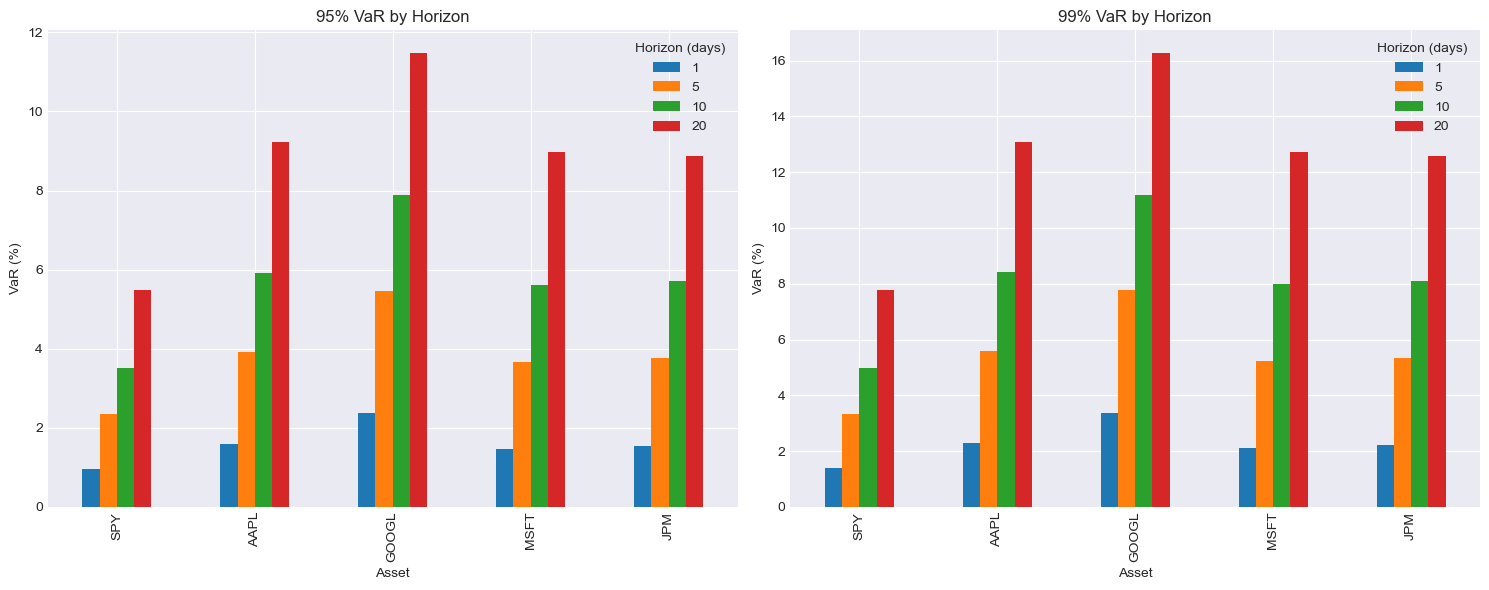

In [18]:
# Calculate VaR using GARCH volatility forecasts
def calculate_garch_var(returns, garch_result, confidence_level=0.95, horizon=1):
    """
    Calculate VaR using GARCH volatility forecast
    """
    # Get volatility forecast
    vol_forecast = garch_result.forecast(horizon=horizon)
    sigma = np.sqrt(vol_forecast.variance.values[-1, :].sum())
    
    # Get distribution parameters
    if hasattr(garch_result, 'dist'):
        if garch_result.dist.name == 'Normal':
            z_score = stats.norm.ppf(1 - confidence_level)
        elif garch_result.dist.name == 'Standardized Student\'s t':
            nu = garch_result.params['nu']
            z_score = stats.t.ppf(1 - confidence_level, nu)
    else:
        z_score = stats.norm.ppf(1 - confidence_level)
    
    # Calculate VaR
    mean_forecast = returns.mean()  # Could use more sophisticated mean model
    var = mean_forecast + z_score * sigma
    
    return var, sigma

# Calculate VaR for different horizons
horizons = [1, 5, 10, 20]
confidence_levels = [0.95, 0.99]

var_results = pd.DataFrame()

for ticker in tickers:
    for horizon in horizons:
        for conf in confidence_levels:
            var, vol = calculate_garch_var(
                returns[ticker], 
                portfolio_garch_models[ticker],
                confidence_level=conf,
                horizon=horizon
            )
            var_results.loc[ticker, f'{int(conf*100)}% VaR ({horizon}d)'] = var

print("Value at Risk Estimates (%) using GARCH:")
print("=" * 80)
print(var_results.round(2))

# Visualize VaR term structure
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, conf in enumerate(confidence_levels):
    var_data = []
    for horizon in horizons:
        vars = []
        for ticker in tickers:
            var, _ = calculate_garch_var(
                returns[ticker],
                portfolio_garch_models[ticker],
                confidence_level=conf,
                horizon=horizon
            )
            vars.append(-var)  # Convert to positive for display
        var_data.append(vars)
    
    var_df = pd.DataFrame(var_data, columns=tickers, index=horizons).T
    
    var_df.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{int(conf*100)}% VaR by Horizon')
    axes[i].set_xlabel('Asset')
    axes[i].set_ylabel('VaR (%)')
    axes[i].legend(title='Horizon (days)')

plt.tight_layout()
plt.show()

## 8. Volatility Trading Signals

In [20]:
# Generate trading signals based on volatility regime
def generate_volatility_signals(conditional_vol, lookback=252):
    """
    Generate trading signals based on volatility regime
    """
    # Calculate volatility percentiles
    vol_percentile = conditional_vol.rolling(lookback).rank(pct=True)
    
    # Define regimes
    signals = pd.Series(index=conditional_vol.index, dtype=float)
    signals[vol_percentile < 0.25] = 1.5   # Low vol: increase exposure
    signals[(vol_percentile >= 0.25) & (vol_percentile < 0.75)] = 1.0  # Normal
    signals[vol_percentile >= 0.75] = 0.5  # High vol: reduce exposure
    
    return signals, vol_percentile

# Apply to SPY
spy_vol = portfolio_garch_models['SPY'].conditional_volatility * np.sqrt(252)
signals, vol_percentile = generate_volatility_signals(spy_vol)

# Backtest the strategy
spy_ret = returns['SPY'] / 100  # Convert back to decimal
strategy_returns = spy_ret * signals.shift(1)  # Use previous day's signal
buy_hold_returns = spy_ret

# Calculate cumulative returns
cum_strategy = (1 + strategy_returns).cumprod()
cum_buy_hold = (1 + buy_hold_returns).cumprod()

# Create visualization
fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                    subplot_titles=('Volatility Percentile and Signals',
                                   'Position Sizing',
                                   'Cumulative Performance'),
                    row_heights=[0.3, 0.2, 0.5])

# Volatility percentile
fig.add_trace(go.Scatter(x=vol_percentile.index, y=vol_percentile * 100,
                        mode='lines', name='Vol Percentile',
                        line=dict(color='blue')),
              row=1, col=1)

# Add regime lines
fig.add_hline(y=25, line_dash="dash", line_color="green", row=1, col=1)
fig.add_hline(y=75, line_dash="dash", line_color="red", row=1, col=1)

# Position sizing
fig.add_trace(go.Scatter(x=signals.index, y=signals,
                        mode='lines', name='Position Size',
                        line=dict(color='orange', width=1)),
              row=2, col=1)

# Performance
fig.add_trace(go.Scatter(x=cum_strategy.index, y=(cum_strategy - 1) * 100,
                        mode='lines', name='Vol Strategy',
                        line=dict(color='green')),
              row=3, col=1)
fig.add_trace(go.Scatter(x=cum_buy_hold.index, y=(cum_buy_hold - 1) * 100,
                        mode='lines', name='Buy & Hold',
                        line=dict(color='blue')),
              row=3, col=1)

fig.update_yaxes(title_text="Percentile", row=1, col=1)
fig.update_yaxes(title_text="Size", row=2, col=1)
fig.update_yaxes(title_text="Return (%)", row=3, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)

fig.update_layout(height=900, title_text="Volatility-Based Trading Strategy")
fig.show()

# Performance metrics
def calculate_performance_metrics(returns):
    annual_return = returns.mean() * 252
    annual_vol = returns.std() * np.sqrt(252)
    sharpe = annual_return / annual_vol
    max_dd = (1 + returns).cumprod().div((1 + returns).cumprod().cummax()).min() - 1
    
    return {
        'Annual Return': f"{annual_return:.2%}",
        'Annual Volatility': f"{annual_vol:.2%}",
        'Sharpe Ratio': f"{sharpe:.3f}",
        'Max Drawdown': f"{max_dd:.2%}"
    }

print("\nStrategy Performance Comparison:")
print("=" * 50)
perf_comparison = pd.DataFrame({
    'Vol Strategy': calculate_performance_metrics(strategy_returns.dropna()),
    'Buy & Hold': calculate_performance_metrics(buy_hold_returns)
}).T
print(perf_comparison)


Strategy Performance Comparison:
             Annual Return Annual Volatility Sharpe Ratio Max Drawdown
Vol Strategy        13.47%            15.23%        0.884      -22.28%
Buy & Hold          12.79%            18.10%        0.707      -33.72%


## 9. Multi-Asset Volatility Modeling

In [22]:
# Calculate correlation dynamics using DCC-GARCH concepts
# Note: Full DCC-GARCH requires specialized libraries, this is a simplified approach

# Standardize returns using GARCH volatilities
standardized_returns = pd.DataFrame()
for ticker in tickers:
    std_ret = returns[ticker] / portfolio_garch_models[ticker].conditional_volatility
    standardized_returns[ticker] = std_ret

# Calculate rolling correlations of standardized returns
rolling_corr = standardized_returns.rolling(window=63).corr()

# Extract specific pair correlations
pairs = [('SPY', 'AAPL'), ('SPY', 'JPM'), ('AAPL', 'GOOGL')]
corr_series = {}

for asset1, asset2 in pairs:
    corr_values = []
    dates = []
    
    for date in standardized_returns.index[63:]:
        if date in rolling_corr.index:
            corr_value = rolling_corr.loc[(date, asset1), asset2]
            if not np.isnan(corr_value):
                corr_values.append(corr_value)
                dates.append(date)
    
    corr_series[f'{asset1}-{asset2}'] = pd.Series(corr_values, index=dates)

# Visualize dynamic correlations
fig = go.Figure()

for pair_name, corr_data in corr_series.items():
    fig.add_trace(go.Scatter(
        x=corr_data.index,
        y=corr_data.values,
        mode='lines',
        name=pair_name
    ))

fig.update_layout(
    title='Dynamic Correlations (GARCH-Standardized Returns)',
    xaxis_title='Date',
    yaxis_title='Correlation',
    hovermode='x unified',
    height=500
)

# Add crisis periods
fig.add_vrect(x0="2020-02-19", x1="2020-03-23", 
              fillcolor="red", opacity=0.1, annotation_text="COVID")
fig.add_vrect(x0="2022-01-03", x1="2022-06-16", 
              fillcolor="orange", opacity=0.1, annotation_text="2022 Bear")

fig.show()

# Portfolio volatility forecast
# Simple approach: use current correlations and individual volatility forecasts
current_corr = standardized_returns.iloc[-252:].corr()
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # Equal weight portfolio

# Individual volatility forecasts (20-day)
vol_forecasts = []
for ticker in tickers:
    forecast = portfolio_garch_models[ticker].forecast(horizon=20)
    vol = np.sqrt(forecast.variance.values[-1, -1]) * np.sqrt(252)
    vol_forecasts.append(vol)

vol_forecasts = np.array(vol_forecasts)

# Portfolio variance
portfolio_variance = np.dot(weights, np.dot(np.diag(vol_forecasts**2), 
                           np.dot(current_corr.values, weights)))
portfolio_vol_forecast = np.sqrt(portfolio_variance)

print("\n20-Day Ahead Volatility Forecasts (Annualized):")
print("=" * 50)
for ticker, vol in zip(tickers, vol_forecasts):
    print(f"{ticker}: {vol:.2f}%")
print(f"\nEqual-Weight Portfolio: {portfolio_vol_forecast:.2f}%")
print(f"Diversification Ratio: {vol_forecasts.mean() / portfolio_vol_forecast:.2f}")


20-Day Ahead Volatility Forecasts (Annualized):
SPY: 13.72%
AAPL: 22.95%
GOOGL: 26.14%
MSFT: 22.97%
JPM: 21.91%

Equal-Weight Portfolio: 15.98%
Diversification Ratio: 1.35


## Key Takeaways and Implementation Guide

### 1. **GARCH Model Selection**
- **GARCH(1,1)**: Good baseline for most assets
- **GJR-GARCH**: Captures leverage effect (bad news increases volatility more)
- **EGARCH**: No parameter restrictions, captures asymmetry
- **Student-t distribution**: Better for fat tails than normal

### 2. **Practical Applications**
- **Dynamic Position Sizing**: Reduce exposure in high volatility regimes
- **Risk Budgeting**: Allocate risk based on forecasted volatility
- **Option Pricing**: More accurate volatility inputs
- **VaR Calculation**: Time-varying risk estimates

### 3. **Implementation Considerations**
- **Model Re-estimation**: Update parameters weekly/monthly
- **Regime Detection**: Consider regime-switching models for structural breaks
- **Multi-asset**: Use DCC-GARCH for full correlation dynamics
- **Forecast Evaluation**: Track forecast accuracy with realized volatility

### 4. **Code Integration**
```python
# Example: Daily volatility update for risk management
def update_portfolio_risk(returns_df, current_weights):
    # Fit GARCH models
    vol_forecasts = {}
    for ticker in returns_df.columns:
        model = arch_model(returns_df[ticker], vol='Garch', p=1, q=1, dist='t')
        result = model.fit(disp='off', show_warning=False)
        
        # 1-day ahead forecast
        forecast = result.forecast(horizon=1)
        vol_forecasts[ticker] = np.sqrt(forecast.variance.values[-1, 0])
    
    # Calculate portfolio volatility
    # ... (correlation calculation)
    
    return vol_forecasts
```

### 5. **Next Steps**
- Implement full DCC-GARCH for correlation dynamics
- Add regime-switching capabilities
- Integrate with real-time data feeds
- Develop volatility arbitrage strategies
- Create automated rebalancing based on volatility forecasts